Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [1]:
import logging
from itertools import combinations
import pandas as pd
import numpy as np
import geopy.distance
import networkx as nx
from icecream import ic
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from itertools import accumulate
from dataclasses import dataclass

#logging.basicConfig(level=logging.DEBUG)

## Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

In [2]:
CITIES = pd.read_csv('cities/italy.csv', header=None, names=['name', 'lat', 'lon'])
#CITIES = pd.read_csv('cities/vanuatu.csv', header=None, names=['name', 'lat', 'lon'])
#CITIES = pd.read_csv('cities/russia.csv', header=None, names=['name', 'lat', 'lon'])
#CITIES = pd.read_csv('cities/us.csv', header=None, names=['name', 'lat', 'lon'])
#CITIES = pd.read_csv('cities/china.csv', header=None, names=['name', 'lat', 'lon'])
CITIES.head(10)

,name,lat,lon
0,Ancona,43.60,13.50
1,Andria,41.23,16.29
2,Bari,41.12,16.87
3,Bergamo,45.70,9.67
4,Bologna,44.50,11.34
5,Bolzano,46.50,11.35
6,Brescia,45.55,10.22
7,Cagliari,39.22,9.10
8,Catania,37.50,15.08
9,Ferrara,44.84,11.61


In [3]:
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geopy.distance.geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km

In [4]:
def tsp_cost(tsp):
    assert tsp[0] == tsp[-1]
    assert set(tsp) == set(range(len(CITIES)))
    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

## First Greedy Algorithm

Professor's solution, start from the first city and go to the nearest one, iterate until we visit all the cities. Then we close the cycle by returning to the first city.

In [5]:
visited = np.full(len(CITIES), False)
dist = DIST_MATRIX.copy()
city = 0
visited[city] = True
tsp = list()
tsp.append(int(city))
while not np.all(visited):
    dist[:, city] = np.inf
    closest = np.argmin(dist[city])
    #logging.debug(f"step: {CITIES.at[city,'name']} -> {CITIES.at[closest,'name']} ({DIST_MATRIX[city,closest]:.2f}km)")
    visited[closest] = True
    city = closest
    tsp.append(int(city))
#logging.debug(f"step: {CITIES.at[tsp[-1],'name']} -> {CITIES.at[tsp[0],'name']} ({DIST_MATRIX[tsp[-1],tsp[0]]:.2f}km)")
tsp.append(tsp[0])
f"result: Found a path of {len(tsp)-1} steps, total length {tsp_cost(tsp):.2f}km"

'result: Found a path of 46 steps, total length 4436.03km'

## Second Greedy Algorithm

Professor's solution,

In [6]:
def cyclic(edges):
    G = nx.Graps()
    edges = [list(e) for e, _ in edges]
    G.add_edge_from(edges)
    try:
        nx.find_cycle(G)
        return True
    except:
        return False

In [7]:
segments = [({c1, c2}, float(DIST_MATRIX[c1, c2])) for c1, c2 in combinations(range(len(CITIES)), 2)] #[({c1, c2}, len)]
visited = set()
edges = set()

shortest = next(_ for _ in sorted(segments, key=lambda e: e[1]))
visited |= shortest[0]
#edges |= {tuple(shortest[0])}
#segments = [s for s in segments if not cyclic(edges | {tuple(s[0])})]


## HC

This solutions is not good both in terms of number of steps and cost of the solution, using insert_mutation (minimize changes in the order) improves performance slightly compared to using swap_mutation

In [8]:
def swap_mutation(tsp: list):
    new_tsp = tsp.copy()
    pos1 = np.random.randint(0, len(CITIES))
    pos2 = np.random.randint(0, len(CITIES))
    while pos2 == pos1:
        pos2 = np.random.randint(0, len(CITIES))
    new_tsp[pos1] = tsp[pos2]
    new_tsp[pos2] = tsp[pos1]
    return new_tsp

def insert_mutation(tsp: list):
    new_tsp = tsp.copy()
    pos1 = np.random.randint(0, len(CITIES))
    pos2 = np.random.randint(0, len(CITIES))
    while pos2 == pos1:
        pos2 = np.random.randint(0, len(CITIES))
    if pos1 > pos2:
        temp = pos1
        pos1 = pos2
        pos2 = temp
    x = pos2
    while pos1 != pos2:
        pos1 += 1
        new_tsp[pos1] = tsp[x]
        x = pos1
    return new_tsp

def fitness(tsp: list):
    f_tsp = tsp.copy()
    f_tsp.append(tsp[0])
    return -float(tsp_cost(f_tsp))

  0%|          | 0/10000 [00:00<?, ?it/s]

'result: Found a path of 10000 steps, total length 5651.88km'

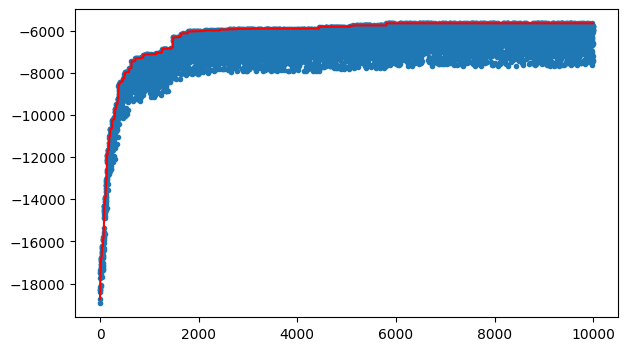

In [9]:
#generate a solution that does not return to the initial city
tsp = list()
for i in range(0, len(CITIES)):
    tsp.append(int(i))
#HC
f_tsp = fitness(tsp)
history = [fitness(tsp)]
for steps in tqdm(range(10000)):
    new_tsp = insert_mutation(tsp)
    f = fitness(new_tsp)
    history.append(f)
    if f > f_tsp:
        tsp = new_tsp
        f_tsp = fitness(tsp)
tsp.append(tsp[0])
plt.figure(figsize=(7, 4))
plt.plot(range(len(history)), list(accumulate(history, max)), color="red")
_ = plt.scatter(range(len(history)), history, marker=".")
f"result: Found a path of {steps+1} steps, total length {tsp_cost(tsp):.2f}km"

## Simulated Annealing

'result: Found a path of 10000 steps, total length 6117.68km'

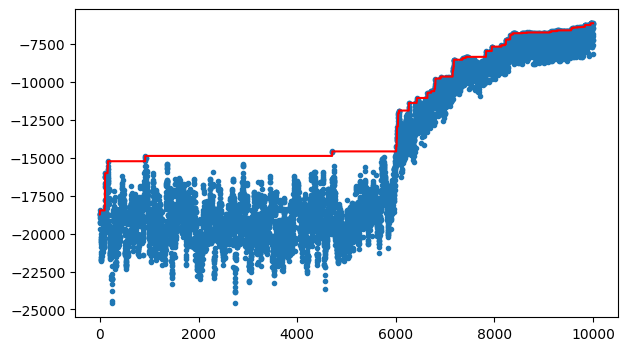

In [10]:
temp=300
cooling_rate=0.999
#generate a solution that does not return to the initial city
tsp = list()
for i in range(0, len(CITIES)):
    tsp.append(int(i))
f_tsp = fitness(tsp)
history = [fitness(tsp)]
for steps in range(10000):
    new_tsp = insert_mutation(tsp)
    f = fitness(new_tsp)
    history.append(f)
    delta_fitness = f - f_tsp
    # Acceptance criterion: accept if the new solution has better fitness, or probabilistically if worse
    if delta_fitness > 0 or np.random.randint(0, 1) < np.exp(delta_fitness / temp):
        tsp = new_tsp
        f_tsp = f
    temp *= cooling_rate
    if temp < 1e-5:
        break
tsp.append(tsp[0])
plt.figure(figsize=(7, 4))
plt.plot(range(len(history)), list(accumulate(history, max)), color="red")
_ = plt.scatter(range(len(history)), history, marker=".")
f"result: Found a path of {steps+1} steps, total length {tsp_cost(tsp):.2f}km"


## EA

EA with cycle crossover and insert mutation with an HYPERMODERN model

In [11]:
@dataclass
class Individual:
    genome: np.ndarray
    fitness: float = None

def fitnessEA(individual: Individual):
    f_tsp = individual.genome.copy()
    f_tsp.append(individual.genome[0])
    return -float(tsp_cost(f_tsp))

def parent_selection(population):
    candidates = sorted(np.random.choice(population, 2), key=lambda e: e.fitness, reverse = True)
    return candidates[0]

def xover(p1: Individual, p2: Individual):
    sol = [-1 for _ in range(len(CITIES))]
    #cycle crossover
    pos1 = np.random.randint(0, len(CITIES))
    pos2 = np.random.randint(0, len(CITIES))
    while pos2 == pos1:
        pos2 = np.random.randint(0, len(CITIES))
    if pos1 > pos2:
        temp = pos1
        pos1 = pos2
        pos2 = temp
    mancanti = p2.genome.copy()
    for x in range(pos1, pos2):
        sol[x] = p1.genome[x]
        mancanti.remove(sol[x])
    for x in range(len(CITIES)):
        if sol[x] == -1:
            sol[x] = mancanti.pop(-1)
    return Individual(sol)

def mutation(p: Individual):
    #insert_mutation
    return Individual(insert_mutation(p.genome))

POPULATION_SIZE = 10
OFFSPRING_SIZE = 4
MAX_GENERATIONS = 1000

#genero la popolazione iniziale
i = list()
for x in range(len(CITIES)):
    i.append(x)
population = [Individual(i) for _ in range(POPULATION_SIZE)]
for i in population:
    i.fitness = fitnessEA(i)
population.sort(key=lambda i: i.fitness, reverse = True)
#HYPERMODERN
for g in tqdm(range(MAX_GENERATIONS)):
    #genero gli offspring
    offspring = []
    for _ in range(OFFSPRING_SIZE):
        if np.random.random() < 0.3:
            #mutation
            p = parent_selection(population)
            o = mutation(p)
        else:
            #crossover
            i1 = parent_selection(population)
            i2 = parent_selection(population)
            o = xover(i1, i2)
        offspring.append(o)
    #valuto il genome calcolando fitness
    for i in offspring:
        i.fitness = fitnessEA(i)
    #reinserisco gli offspring nella popolazione e tengo solo i primi POPULATION_SIZE individui
    population.extend(offspring)
    population.sort(key=lambda i: i.fitness, reverse = True)
    population = population[:POPULATION_SIZE]
f"result: Found a path of {g+1} steps, total length {-population[0].fitness:.2f}km"

  0%|          | 0/1000 [00:00<?, ?it/s]

'result: Found a path of 1000 steps, total length 5369.43km'

### sources
- prof example
- past exercises
- slides